In [9]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from simplified_monorotor import Monorotor
import plotting
import testing
import trajectories

pylab.rcParams['figure.figsize'] = 10,10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feedforward control

The feedforward term captures the acceleration of the target path and adds to the $\bar{u}_1$ calculated by PD controller. 

$$
\ddot{z} = \bar{u}_1= k_p(z_t-z)+k_d(z_t-z)+\ddot{z}
$$ 

#### TODO - Implement PD controller WITH feed forward acceleration

Modify `thrust_control` to incorporate the feedforward term into the PD Controller math.

$$
\begin{align}
e &= z_{\text{target}} - z_{\text{actual}} \\
\dot{e} &= \dot{z}_{\text{target}} - \dot{z}_{\text{actual}} \\
\bar{u}_1 &= k_p e + k_d \dot{e} + \ddot{z}_{\text{ff}} \\
u_1 &= m(g - \bar{u}_1)
\end{align}
$$

In [10]:
class PDController:
    
    def __init__(self, k_p, k_d, m):
        self.k_p = k_p
        self.k_d = k_d
        self.vehicle_mass = m
        self.g = 9.81
        
    def tune(self, delta, omega_n):
        self.k_p = omega_n ** 2
        self.k_d = 2 * delta * omega_n
    
    def thrust_control(self,
                z_target, 
                z_actual, 
                z_dot_target, 
                z_dot_actual,
                z_dot_dot_ff=0.0):
        
        err = z_target - z_actual
        err_dot = z_dot_target - z_dot_actual
        u_bar = self.k_p * err + self.k_d * err_dot + z_dot_dot_ff
        u = self.vehicle_mass * (self.g - u_bar) 
        
        return u
    
testing.pd_controller_test(PDController, feed_forward=True)

Tests pass


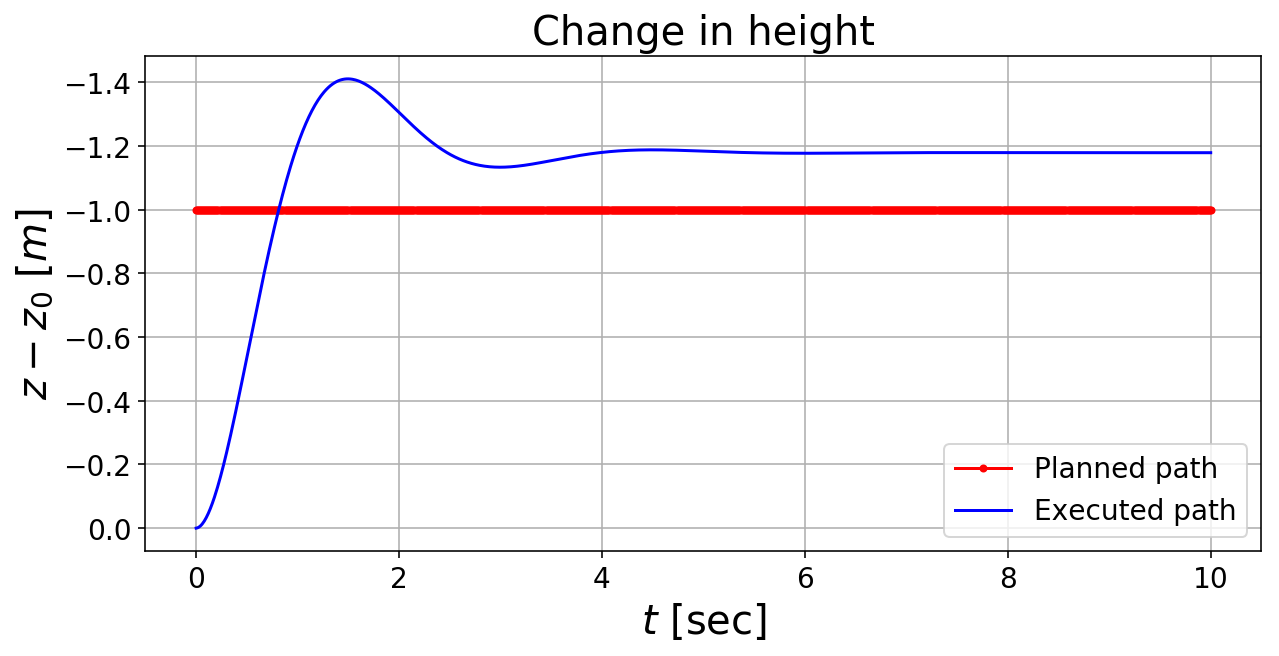

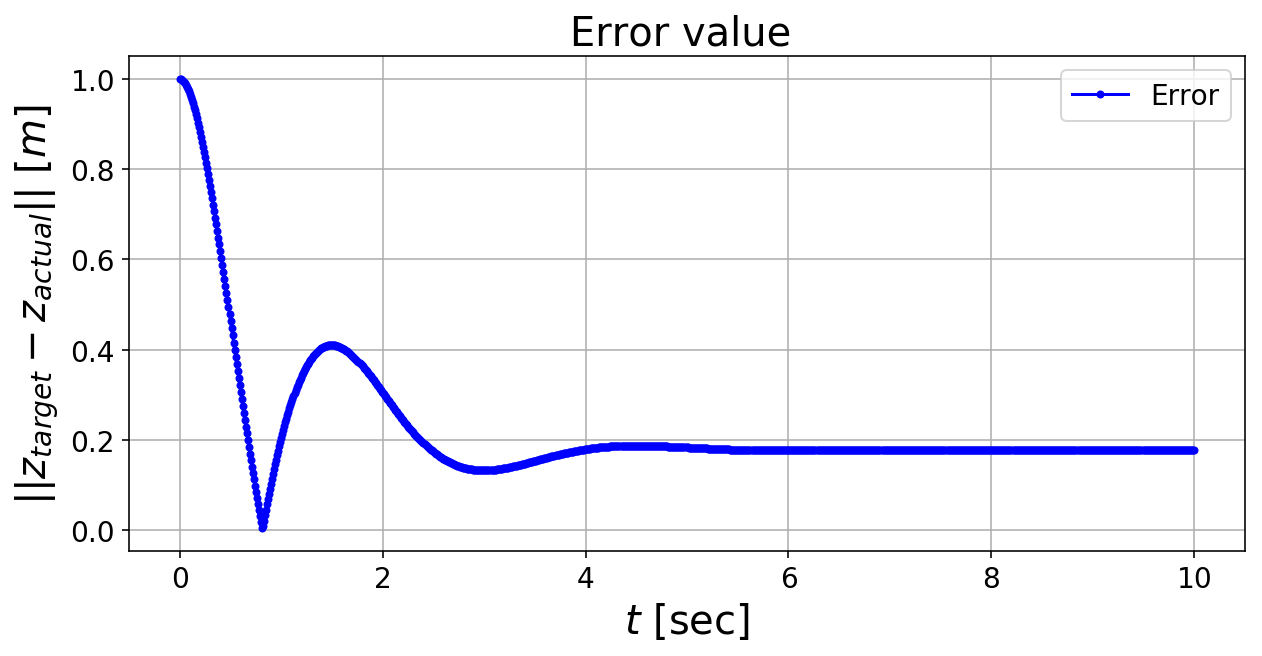

In [11]:
MASS_ERROR = 1.1

drone = Monorotor()
perceived_mass = drone.m * MASS_ERROR
controller = PDController(5.0, 2.0, perceived_mass)

t, z_path, z_dot_path = trajectories.step()
dt = t[1] - t[0]

history = []
for z_target, z_dot_target in zip(z_path, z_dot_path):
    z_actual = drone.z
    z_dot_actual = drone.z_dot
    u = controller.thrust_control(z_target, z_actual, 
                                  z_dot_target, z_dot_actual)
    drone.thrust = u
    drone.advance_state(dt)
    history.append(drone.X)
    
z_actual = [h[0] for h in history]
plotting.compare_planned_to_actual(z_actual, z_path, t)   

[Solution](/notebooks/PD%20with%20FF%20Solution.ipynb)